In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# 定义生成对抗网络（GAN）的生成器
class Generator(nn.Module):
    def __init__(self, latent_dim=128, img_size=28, num_channels=1):
        super(Generator, self).__init__()
        self.img_size = img_size
        self.num_channels = num_channels

        self.main = nn.Sequential(
            # 输入: 噪声 Z，维度为 [B, latent_dim, 1, 1] (经过全连接层后)
            # 经过全连接层将噪声向量转换为适合反卷积的维度
            nn.Linear(latent_dim, 256 * (img_size // 4) * (img_size // 4)),
            nn.BatchNorm1d(256 * (img_size // 4) * (img_size // 4)),
            nn.ReLU(True),

            # 将一维向量 reshape 成特征图
            nn.Unflatten(1, (256, img_size // 4, img_size // 4)), # 256 是通道数，img_size//4 是 H 和 W

            # 反卷积层 1: 256x7x7 -> 128x14x14
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # 反卷积层 2: 128x14x14 -> 64x28x28
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # 反卷积层 3: 64x28x28 -> 1x28x28 (输出图像)
            nn.ConvTranspose2d(64, num_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Tanh() # 将像素值缩放到 [-1, 1]
        )

    def forward(self, input):
        # 首先通过全连接层将噪声维度扩展
        x = self.main[0](input)
        x = self.main[1](x)
        x = self.main[2](x)
        # 然后进行 Unflatten
        x = self.main[3](x)
        # 接着进行反卷积
        x = self.main[4:](x)
        return x


class Discriminator(nn.Module):
    def __init__(self, img_channels=1, feature_maps_d=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 输入图像 (batch_size, img_channels, 28, 28)
            nn.Conv2d(img_channels, feature_maps_d, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # (batch_size, feature_maps_d, 14, 14)

            nn.Conv2d(feature_maps_d, feature_maps_d * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps_d * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # (batch_size, feature_maps_d*2, 7, 7)

            nn.Conv2d(feature_maps_d * 2, feature_maps_d * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps_d * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # (batch_size, feature_maps_d*4, 3, 3) (或者 4x4 取决于具体计算)

            # 最终的卷积层输出到1
            nn.Conv2d(feature_maps_d * 4, 1, 3, 1, 0, bias=False), # 调整核大小以适应最终尺寸
            nn.Sigmoid() # 输出一个介于0和1之间的概率
        )

    def forward(self, input):
        # 确保输入是图像格式 (batch_size, channels, H, W)
        # 如果你的 dataloader 已经输出 (N, 1, 28, 28)，则不需要 view
        return self.main(input.view(input.size(0), 1, 28, 28)) # 对于28x28的单通道图像


def train_gan(G, D, dataloader, epochs, device,
              lr_D=2e-4, lr_G=2e-4,
              beta1=0.5,
              noise_dim=128):

    criterion = nn.BCELoss() # 二元交叉熵损失

    optimizer_D = torch.optim.Adam(D.parameters(), lr=lr_D, betas=(beta1, 0.999))
    optimizer_G = torch.optim.Adam(G.parameters(), lr=lr_G, betas=(beta1, 0.999))


    print("开始GAN训练...")
    for epoch in range(epochs):
        D_loss_total = 0
        G_loss_total = 0
        loader_len = len(dataloader)

        for i, data in tqdm(enumerate(dataloader), desc=f"Epoch {epoch+1}/{epochs}", total=loader_len):
            real_images, _ = data
            B = real_images.size(0)
            real_images = real_images.view(-1, 784).to(device) # 假设28x28图像展平为784

            # --- 训练判别器 (D) ---
            optimizer_D.zero_grad()

            # 使用真实图像进行训练
            real_outputs = D(real_images)
            # 对真实图像使用软标签，防止D过于自信
            real_labels = torch.full((B,), 0.9, device=device) # 真实图像的软标签
            errD_real = criterion(real_outputs.view(-1), real_labels)
            errD_real.backward()

            # 使用假图像进行训练
            noise = torch.randn(B, noise_dim, device=device)
            fake_images = G(noise)
            # print(fake_images.shape)
            # 在D的训练中，G的输出需要 .detach()，这样G的梯度不会在这里计算
            fake_output = D(fake_images.detach())
            # 对D的假图像也使用软标签，但值更低
            fake_labels = torch.full((B,), 0.1, device=device) # 假图像的软标签
            errD_fake = criterion(fake_output.view(-1), fake_labels)
            errD_fake.backward()

            errD = errD_real + errD_fake
            optimizer_D.step()
            D_loss_total += errD.item()

            # --- 训练生成器 (G) ---
            optimizer_G.zero_grad()
            # 生成新的假图像，避免使用D训练时旧的图像
            noise = torch.randn(B, noise_dim, device=device)
            fake_images = G(noise)
            # D对G生成的图像的输出。这里至关重要，不要使用 detach()。
            output = D(fake_images)
            # G希望D将假图像分类为真实（目标标签为1.0或软标签）
            # 这里我们使用完整的1.0作为G的目标，以强烈鼓励它欺骗D
            errG = criterion(output.view(-1), torch.full((B,), 1.0, device=device))
            errG.backward()
            optimizer_G.step()
            G_loss_total += errG.item()

        # --- Epoch 结束总结 ---
        d_loss_avg = D_loss_total / loader_len
        # 根据G的更新次数调整平均损失
        g_loss_avg = G_loss_total / loader_len

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"D Loss: {d_loss_avg:.4f}, G Loss: {g_loss_avg:.4f}")

In [3]:
from torchvision import transforms

batch_size = 256
epochs = 100


transform = transforms.Compose([
    transforms.ToTensor(),  # 转换为 Tensor
    transforms.Normalize((0.1307,), (0.3081,))  # 标准化
])

# 下载 MNIST 数据集
mnist_train = MNIST(root='../../dataset_file/mnist_raw', train=True, download=False,transform=transform)
dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

# 初始化生成器和判别器
G = Generator().to(device)
D = Discriminator().to(device)

# 训练GAN
train_gan(G, D, dataloader, epochs=epochs, device=device)

开始GAN训练...


Epoch 1/100: 100%|██████████| 235/235 [00:11<00:00, 20.51it/s]


Epoch [1/100] D Loss: 0.6833, G Loss: 2.4822


Epoch 2/100: 100%|██████████| 235/235 [00:07<00:00, 31.09it/s]


Epoch [2/100] D Loss: 0.7067, G Loss: 2.3748


Epoch 3/100: 100%|██████████| 235/235 [00:07<00:00, 31.24it/s]


Epoch [3/100] D Loss: 0.6899, G Loss: 2.3782


Epoch 4/100: 100%|██████████| 235/235 [00:07<00:00, 31.24it/s]


Epoch [4/100] D Loss: 0.6712, G Loss: 2.3649


Epoch 5/100: 100%|██████████| 235/235 [00:07<00:00, 31.21it/s]


Epoch [5/100] D Loss: 0.6596, G Loss: 2.3336


Epoch 6/100: 100%|██████████| 235/235 [00:07<00:00, 31.16it/s]


Epoch [6/100] D Loss: 0.6566, G Loss: 2.3213


Epoch 7/100: 100%|██████████| 235/235 [00:07<00:00, 31.14it/s]


Epoch [7/100] D Loss: 0.6848, G Loss: 2.3804


Epoch 8/100: 100%|██████████| 235/235 [00:07<00:00, 31.22it/s]


Epoch [8/100] D Loss: 0.6582, G Loss: 2.3205


Epoch 9/100: 100%|██████████| 235/235 [00:07<00:00, 31.24it/s]


Epoch [9/100] D Loss: 0.6548, G Loss: 2.3158


Epoch 10/100: 100%|██████████| 235/235 [00:07<00:00, 31.30it/s]


Epoch [10/100] D Loss: 0.6546, G Loss: 2.3101


Epoch 11/100: 100%|██████████| 235/235 [00:07<00:00, 31.23it/s]


Epoch [11/100] D Loss: 0.6551, G Loss: 2.3126


Epoch 12/100: 100%|██████████| 235/235 [00:08<00:00, 29.37it/s]


Epoch [12/100] D Loss: 0.6584, G Loss: 2.3193


Epoch 13/100: 100%|██████████| 235/235 [00:07<00:00, 31.44it/s]


Epoch [13/100] D Loss: 0.7047, G Loss: 2.3374


Epoch 14/100: 100%|██████████| 235/235 [00:07<00:00, 30.17it/s]


Epoch [14/100] D Loss: 0.6606, G Loss: 2.3185


Epoch 15/100: 100%|██████████| 235/235 [00:07<00:00, 30.39it/s]


Epoch [15/100] D Loss: 0.6778, G Loss: 2.3037


Epoch 16/100: 100%|██████████| 235/235 [00:07<00:00, 30.34it/s]


Epoch [16/100] D Loss: 0.7006, G Loss: 2.3314


Epoch 17/100: 100%|██████████| 235/235 [00:07<00:00, 31.23it/s]


Epoch [17/100] D Loss: 0.6926, G Loss: 2.2916


Epoch 18/100: 100%|██████████| 235/235 [00:07<00:00, 31.53it/s]


Epoch [18/100] D Loss: 0.6906, G Loss: 2.3161


Epoch 19/100: 100%|██████████| 235/235 [00:07<00:00, 30.43it/s]


Epoch [19/100] D Loss: 0.6566, G Loss: 2.3066


Epoch 20/100: 100%|██████████| 235/235 [00:07<00:00, 30.99it/s]


Epoch [20/100] D Loss: 0.6653, G Loss: 2.3230


Epoch 21/100: 100%|██████████| 235/235 [00:07<00:00, 30.80it/s]


Epoch [21/100] D Loss: 0.6533, G Loss: 2.3106


Epoch 22/100: 100%|██████████| 235/235 [00:07<00:00, 29.50it/s]


Epoch [22/100] D Loss: 0.6530, G Loss: 2.3056


Epoch 23/100: 100%|██████████| 235/235 [00:07<00:00, 29.98it/s]


Epoch [23/100] D Loss: 0.6522, G Loss: 2.3011


Epoch 24/100: 100%|██████████| 235/235 [00:07<00:00, 30.48it/s]


Epoch [24/100] D Loss: 0.6523, G Loss: 2.2985


Epoch 25/100: 100%|██████████| 235/235 [00:07<00:00, 30.97it/s]


Epoch [25/100] D Loss: 0.6526, G Loss: 2.3106


Epoch 26/100: 100%|██████████| 235/235 [00:07<00:00, 30.42it/s]


Epoch [26/100] D Loss: 0.6522, G Loss: 2.2963


Epoch 27/100: 100%|██████████| 235/235 [00:09<00:00, 24.28it/s]


Epoch [27/100] D Loss: 0.6522, G Loss: 2.3027


Epoch 28/100: 100%|██████████| 235/235 [00:19<00:00, 11.82it/s]


Epoch [28/100] D Loss: 0.6528, G Loss: 2.3194


Epoch 29/100: 100%|██████████| 235/235 [00:19<00:00, 12.05it/s]


Epoch [29/100] D Loss: 0.7189, G Loss: 2.2967


Epoch 30/100: 100%|██████████| 235/235 [00:19<00:00, 11.93it/s]


Epoch [30/100] D Loss: 0.7177, G Loss: 2.2862


Epoch 31/100: 100%|██████████| 235/235 [00:19<00:00, 11.79it/s]


Epoch [31/100] D Loss: 0.7051, G Loss: 2.2962


Epoch 32/100: 100%|██████████| 235/235 [00:19<00:00, 11.89it/s]


Epoch [32/100] D Loss: 0.6979, G Loss: 2.3092


Epoch 33/100: 100%|██████████| 235/235 [00:19<00:00, 11.97it/s]


Epoch [33/100] D Loss: 0.6799, G Loss: 2.3126


Epoch 34/100: 100%|██████████| 235/235 [00:19<00:00, 11.95it/s]


Epoch [34/100] D Loss: 0.6690, G Loss: 2.3134


Epoch 35/100: 100%|██████████| 235/235 [00:19<00:00, 11.88it/s]


Epoch [35/100] D Loss: 0.7027, G Loss: 2.2846


Epoch 36/100: 100%|██████████| 235/235 [00:19<00:00, 11.87it/s]


Epoch [36/100] D Loss: 0.6610, G Loss: 2.3171


Epoch 37/100: 100%|██████████| 235/235 [00:19<00:00, 12.03it/s]


Epoch [37/100] D Loss: 0.6727, G Loss: 2.3112


Epoch 38/100: 100%|██████████| 235/235 [00:19<00:00, 12.14it/s]


Epoch [38/100] D Loss: 0.7231, G Loss: 2.2560


Epoch 39/100: 100%|██████████| 235/235 [00:19<00:00, 12.13it/s]


Epoch [39/100] D Loss: 0.6993, G Loss: 2.2957


Epoch 40/100: 100%|██████████| 235/235 [00:19<00:00, 12.06it/s]


Epoch [40/100] D Loss: 0.6596, G Loss: 2.3146


Epoch 41/100: 100%|██████████| 235/235 [00:19<00:00, 12.01it/s]


Epoch [41/100] D Loss: 0.7149, G Loss: 2.2364


Epoch 42/100: 100%|██████████| 235/235 [00:14<00:00, 15.71it/s]


Epoch [42/100] D Loss: 0.7133, G Loss: 2.2661


Epoch 43/100: 100%|██████████| 235/235 [00:10<00:00, 21.92it/s]


Epoch [43/100] D Loss: 0.6843, G Loss: 2.2870


Epoch 44/100: 100%|██████████| 235/235 [00:19<00:00, 12.07it/s]


Epoch [44/100] D Loss: 0.7469, G Loss: 2.1759


Epoch 45/100: 100%|██████████| 235/235 [00:19<00:00, 12.04it/s]


Epoch [45/100] D Loss: 0.7312, G Loss: 2.2110


Epoch 46/100: 100%|██████████| 235/235 [00:12<00:00, 18.12it/s]


Epoch [46/100] D Loss: 0.7462, G Loss: 2.1447


Epoch 47/100: 100%|██████████| 235/235 [00:07<00:00, 30.49it/s]


Epoch [47/100] D Loss: 0.7591, G Loss: 2.0696


Epoch 48/100: 100%|██████████| 235/235 [00:10<00:00, 22.73it/s]


Epoch [48/100] D Loss: 0.7580, G Loss: 2.0587


Epoch 49/100: 100%|██████████| 235/235 [00:19<00:00, 12.23it/s]


Epoch [49/100] D Loss: 0.7841, G Loss: 1.9115


Epoch 50/100: 100%|██████████| 235/235 [00:19<00:00, 12.06it/s]


Epoch [50/100] D Loss: 0.7844, G Loss: 1.9074


Epoch 51/100: 100%|██████████| 235/235 [00:19<00:00, 11.87it/s]


Epoch [51/100] D Loss: 0.7592, G Loss: 1.9646


Epoch 52/100: 100%|██████████| 235/235 [00:14<00:00, 16.66it/s]


Epoch [52/100] D Loss: 0.7535, G Loss: 1.9548


Epoch 53/100: 100%|██████████| 235/235 [00:07<00:00, 30.12it/s]


Epoch [53/100] D Loss: 0.7629, G Loss: 1.9688


Epoch 54/100: 100%|██████████| 235/235 [00:07<00:00, 29.96it/s]


Epoch [54/100] D Loss: 0.7739, G Loss: 1.9361


Epoch 55/100: 100%|██████████| 235/235 [00:18<00:00, 12.57it/s]


Epoch [55/100] D Loss: 0.7346, G Loss: 2.0376


Epoch 56/100: 100%|██████████| 235/235 [00:19<00:00, 12.27it/s]


Epoch [56/100] D Loss: 0.7694, G Loss: 1.9426


Epoch 57/100: 100%|██████████| 235/235 [00:19<00:00, 12.15it/s]


Epoch [57/100] D Loss: 0.7551, G Loss: 2.0297


Epoch 58/100: 100%|██████████| 235/235 [00:19<00:00, 12.25it/s]


Epoch [58/100] D Loss: 0.7552, G Loss: 1.9701


Epoch 59/100: 100%|██████████| 235/235 [00:19<00:00, 12.30it/s]


Epoch [59/100] D Loss: 0.7510, G Loss: 2.0200


Epoch 60/100: 100%|██████████| 235/235 [00:19<00:00, 12.10it/s]


Epoch [60/100] D Loss: 0.7710, G Loss: 1.9823


Epoch 61/100: 100%|██████████| 235/235 [00:19<00:00, 11.88it/s]


Epoch [61/100] D Loss: 0.7297, G Loss: 2.0643


Epoch 62/100: 100%|██████████| 235/235 [00:19<00:00, 12.30it/s]


Epoch [62/100] D Loss: 0.7872, G Loss: 2.0071


Epoch 63/100: 100%|██████████| 235/235 [00:19<00:00, 11.94it/s]


Epoch [63/100] D Loss: 0.7660, G Loss: 1.8738


Epoch 64/100: 100%|██████████| 235/235 [00:19<00:00, 11.82it/s]


Epoch [64/100] D Loss: 0.7406, G Loss: 2.0661


Epoch 65/100: 100%|██████████| 235/235 [00:19<00:00, 11.88it/s]


Epoch [65/100] D Loss: 0.7350, G Loss: 2.0782


Epoch 66/100: 100%|██████████| 235/235 [00:19<00:00, 11.97it/s]


Epoch [66/100] D Loss: 0.7453, G Loss: 2.0473


Epoch 67/100: 100%|██████████| 235/235 [00:19<00:00, 11.78it/s]


Epoch [67/100] D Loss: 0.7441, G Loss: 2.0106


Epoch 68/100: 100%|██████████| 235/235 [00:20<00:00, 11.60it/s]


Epoch [68/100] D Loss: 0.7895, G Loss: 1.9598


Epoch 69/100: 100%|██████████| 235/235 [00:19<00:00, 11.85it/s]


Epoch [69/100] D Loss: 0.7332, G Loss: 2.0701


Epoch 70/100: 100%|██████████| 235/235 [00:19<00:00, 11.82it/s]


Epoch [70/100] D Loss: 0.7590, G Loss: 1.9976


Epoch 71/100: 100%|██████████| 235/235 [00:20<00:00, 11.75it/s]


Epoch [71/100] D Loss: 0.7326, G Loss: 2.0634


Epoch 72/100: 100%|██████████| 235/235 [00:20<00:00, 11.71it/s]


Epoch [72/100] D Loss: 0.8078, G Loss: 1.9629


Epoch 73/100: 100%|██████████| 235/235 [00:19<00:00, 11.75it/s]


Epoch [73/100] D Loss: 0.7448, G Loss: 2.0764


Epoch 74/100: 100%|██████████| 235/235 [00:18<00:00, 12.53it/s]


Epoch [74/100] D Loss: 0.7443, G Loss: 2.0207


Epoch 75/100: 100%|██████████| 235/235 [00:07<00:00, 30.39it/s]


Epoch [75/100] D Loss: 0.7954, G Loss: 1.9809


Epoch 76/100: 100%|██████████| 235/235 [00:07<00:00, 30.92it/s]


Epoch [76/100] D Loss: 0.7236, G Loss: 2.0584


Epoch 77/100: 100%|██████████| 235/235 [00:07<00:00, 30.65it/s]


Epoch [77/100] D Loss: 0.7467, G Loss: 2.0321


Epoch 78/100: 100%|██████████| 235/235 [00:08<00:00, 29.33it/s]


Epoch [78/100] D Loss: 0.8208, G Loss: 1.9148


Epoch 79/100: 100%|██████████| 235/235 [00:11<00:00, 19.84it/s]


Epoch [79/100] D Loss: 0.7297, G Loss: 2.0716


Epoch 80/100: 100%|██████████| 235/235 [00:20<00:00, 11.43it/s]


Epoch [80/100] D Loss: 0.7382, G Loss: 2.0586


Epoch 81/100: 100%|██████████| 235/235 [00:20<00:00, 11.63it/s]


Epoch [81/100] D Loss: 0.7883, G Loss: 1.9410


Epoch 82/100: 100%|██████████| 235/235 [00:13<00:00, 17.46it/s]


Epoch [82/100] D Loss: 0.7937, G Loss: 2.0143


Epoch 83/100: 100%|██████████| 235/235 [00:15<00:00, 15.59it/s]


Epoch [83/100] D Loss: 0.7574, G Loss: 1.9447


Epoch 84/100: 100%|██████████| 235/235 [00:19<00:00, 12.01it/s]


Epoch [84/100] D Loss: 0.7365, G Loss: 2.0651


Epoch 85/100: 100%|██████████| 235/235 [00:20<00:00, 11.74it/s]


Epoch [85/100] D Loss: 0.7341, G Loss: 2.0863


Epoch 86/100: 100%|██████████| 235/235 [00:19<00:00, 11.84it/s]


Epoch [86/100] D Loss: 0.8188, G Loss: 1.8823


Epoch 87/100: 100%|██████████| 235/235 [00:19<00:00, 11.78it/s]


Epoch [87/100] D Loss: 0.7933, G Loss: 1.9628


Epoch 88/100: 100%|██████████| 235/235 [00:19<00:00, 12.10it/s]


Epoch [88/100] D Loss: 0.7369, G Loss: 2.0363


Epoch 89/100: 100%|██████████| 235/235 [00:19<00:00, 11.84it/s]


Epoch [89/100] D Loss: 0.7308, G Loss: 2.1057


Epoch 90/100: 100%|██████████| 235/235 [00:19<00:00, 11.79it/s]


Epoch [90/100] D Loss: 0.7740, G Loss: 1.9666


Epoch 91/100: 100%|██████████| 235/235 [00:10<00:00, 21.51it/s]


Epoch [91/100] D Loss: 0.7492, G Loss: 2.0259


Epoch 92/100: 100%|██████████| 235/235 [00:08<00:00, 27.55it/s]


Epoch [92/100] D Loss: 0.7914, G Loss: 2.0187


Epoch 93/100: 100%|██████████| 235/235 [00:17<00:00, 13.16it/s]


Epoch [93/100] D Loss: 0.7339, G Loss: 2.0197


Epoch 94/100: 100%|██████████| 235/235 [00:07<00:00, 29.91it/s]


Epoch [94/100] D Loss: 0.7297, G Loss: 2.0940


Epoch 95/100: 100%|██████████| 235/235 [00:07<00:00, 29.56it/s]


Epoch [95/100] D Loss: 0.8250, G Loss: 1.8887


Epoch 96/100: 100%|██████████| 235/235 [00:07<00:00, 29.58it/s]


Epoch [96/100] D Loss: 0.7413, G Loss: 2.0319


Epoch 97/100: 100%|██████████| 235/235 [00:08<00:00, 29.05it/s]


Epoch [97/100] D Loss: 0.7353, G Loss: 2.0669


Epoch 98/100: 100%|██████████| 235/235 [00:17<00:00, 13.10it/s]


Epoch [98/100] D Loss: 0.7380, G Loss: 2.0746


Epoch 99/100: 100%|██████████| 235/235 [00:20<00:00, 11.74it/s]


Epoch [99/100] D Loss: 0.7451, G Loss: 2.0499


Epoch 100/100: 100%|██████████| 235/235 [00:18<00:00, 12.97it/s]

Epoch [100/100] D Loss: 0.8507, G Loss: 1.8578


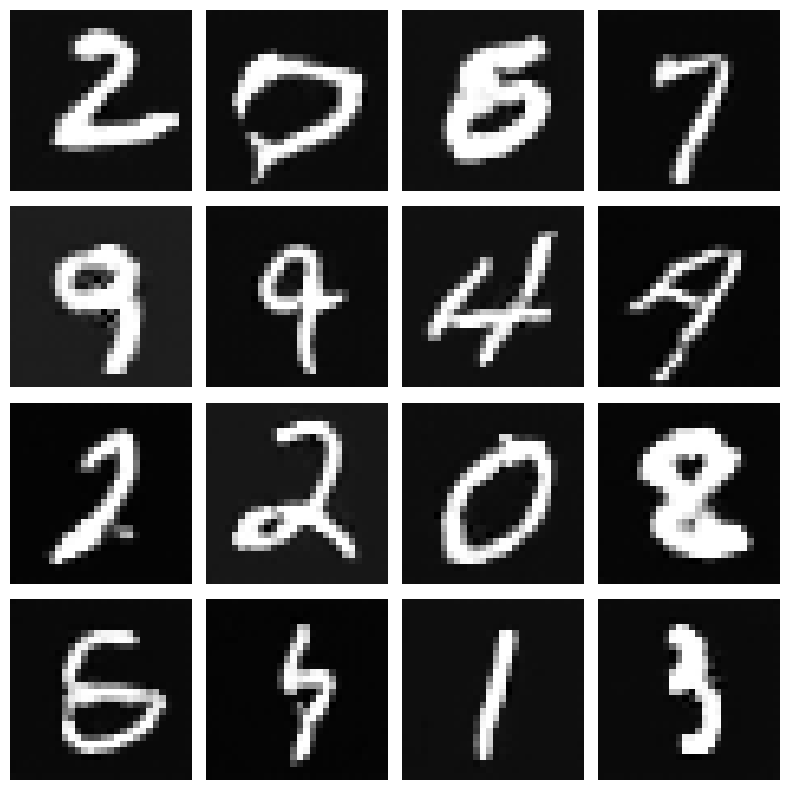

In [7]:
#检测生成质量
import matplotlib.pyplot as plt

def generate_and_plot(G, num_images=16):
    noise = torch.randn(num_images, 128).to(device)
    with torch.no_grad():
        fake_images = G(noise).view(-1, 1, 28, 28).cpu()
    grid_size = int(num_images**0.5)
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(8, 8))
    for i in range(grid_size):
        for j in range(grid_size):
            idx = i * grid_size + j
            if idx < num_images:
                axes[i, j].imshow(fake_images[idx].squeeze(), cmap='gray')
            axes[i, j].axis('off')
    plt.tight_layout()
generate_and_plot(G, num_images=16)

In [5]:
#保存两个模型
torch.save(G.state_dict(), 'generator.pth')
torch.save(D.state_dict(), 'discriminator.pth')